<a href="https://colab.research.google.com/github/shivam37483/Lip-Reading-Model/blob/main/Lip_Reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network

### Importing the libraries

In [ ]:
# !pip list

# !pip install opencv-python matplotlib imageio gdown tensorflow

# opencv ----- pre process the data (drive)
# metaplotlib ------ render the results
# imageio --------- gifs to see frames stacked together
# gdown --------- download dataset

In [ ]:
import os               #navgigate/ traverse to dif file sys.
import  cv2             #import opencv
import tensorflow as tf
import numpy as np         #preprocess any arrays
from typing import List     #type annotation
from matplotlib import pyplot as plt            #render preprocess/postprocess o/p of data loading function
import imageio                      #convert arr into gif

In [ ]:
tf.config.list_physical_devices('GPU')

[]

### Part 1 - Build Data Loading Functions

In [ ]:
# 1)To load up our videos
# 2) To pre process our annotation(sentneces which person i video has talked about)

import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

1. Function


In [ ]:
def load_video(path:str) -> List[float]:        #Take data path(string) and retrun in list of float which contains our video

    cap = cv2.VideoCapture(path)          #video capture instance -> takes a path and loop thru each frames and store it inside array named frames
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):        #starts a loop that iterates for no of frames in video || cv2.CAP_PROP_FRAME_COUN property of cap object to get total no frames in video
      ret, frame = cap.read()                       #reads the next frame from video and assigns the returned values to both. ret indicates whether frame was successfully read and frame contains actual frame data
      frame = tf.image.rgb_to_grayscale(frame)                 #convert to grayscale to reduce processing
      frames.append(frame[190:236,80:220,:])                #only focus/isolate on mouth region (lipnet)
    cap.release()                        # releases video capture object cap to free up system resources

    mean = tf.math.reduce_mean(frames)                       #cal mean (standardising)
    std = tf.math.reduce_std(tf.cast(frames,tf.float32))      #first converts tf.float32 datatype then cal std
    return tf.cast((frames - mean), tf.float32)  / std             #normalizaton

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]              # creates a vocabulary

In [ ]:
# converting num->char and reconverting our text to encoding
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")           #pass thru this data to loss function and cal overall loss || out of vocab token so if ot encounters something outside vocab it will replpace eith blank
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert = True         #yes convert no to char not other way around
)

print(
    f"The vocab is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocab is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
  with open(path, 'r') as f:            # opens the file specified by path perimeter in read mode and assigns it to file object "f"; with ensures file is properly cloesed after reading
    lines = f.readlines()           #reads all lines from file object "f" and stores them in lines list
  tokens = []

  for line in lines:
    line = line.split()            #splits the line into substring (each word) on the basis of " "
    if line[2] != 'sil':
      tokens = [*tokens, ' ', line[2]]               #appends the 3 element of line list to token list along with " "
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

  # splits each token into indivdual unicode characters and returns tf.Tensor object
  # reshapes the tensor into a 1-dimensional tensor, flattening all characters
  # slices the resulting tensor to exclude 1 tensor

Loading data

In [ ]:
# output from this function will be preprocesed data for load allignments & video
def load_data(path:str):
  path = bytes.decode(path.numpy())        #converts path parameter from bytes to string using decode(); which is necessary if path para is ibtained from tf.Tensorflow object
  file_name = path.split('/')[-1].split('.')[0]      #splits path string into substrings using \\ and selects last element(file name with extension); then splits filename.ext using . and selects 1 element(filename without ext)
  video_path = os.path.join('data','s1',f'{file_name}.mpg')         #it constructs a file path anf joins the strings using appropiate path separator for os. REsulting path represnts the video file path
  alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
  frames = load_video(video_path)                   #calls load_video function with para and stores in frames
  alignments = load_alignments(alignment_path)

  return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

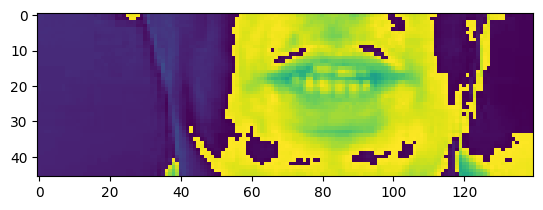

In [ ]:
plt.imshow(frames[40])             #shows persons mouth, which whould show mouth moving if all frames are stacked together

In [ ]:
alignments           #converted raw alignments into encoded sequence which will then be able to pass thru our ml model

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# def mappable_function(path:str) ->List[str]:
#     result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
#     result[0].set_shape([None])  # None indicates that the dimension size is unknown
#     result[1].set_shape([])
#     return result




## Part 2 - Creating Data Pipelining

In [ ]:
# this is how we will sending data to our model
data = tf.data.Dataset.list_files('./data/s1/*.mpg')        # creating our dataset go in resepective and folder and look for anything that ends in 'mpg' which is format for our videos
data = data.shuffle(500)          #specifying cache size of 500, it will grab first 500 and return a value of that
data = data.map(mappable_function)   #we only hv file path till now this will get the actual data present at path0
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))        #we'r batching into group size of 2, each will hv 2 videos and 2 set of alignments; we ensure we hv 75 frames; 40 tokens for each one of alignments if <40 then it will be padded out to 0
data = data.prefetch(tf.data.AUTOTUNE)      #optimizing our pipeline; we are pre-loading as our ml model is training

# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()
alignments

array([[19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39,  3, 39, 26,
         5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39,  9, 39,  6,
         9, 22,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
test = data.as_numpy_iterator()
val = test.next(); val[0]              #return our frames

In [ ]:
fps = 10
frame_duration = 1000 / fps
# val_frames = val[0][1]
# imageio.mimsave('./animation.gif',val_frames, duration=frame_duration)

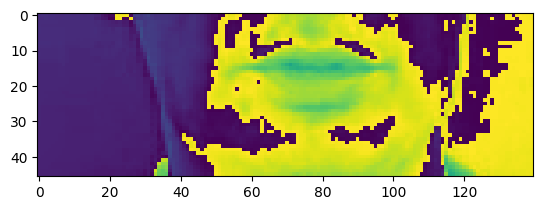

In [ ]:
#1)videos; 1 video of the batch; 1 frame in video
plt.imshow(val[0][0][34])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])         #output that our model should give

<tf.Tensor: shape=(), dtype=string, numpy=b'place red with k zero please'>

## Part 3 - Designing DEep NN



In [ ]:
#we will 3d convulution tp pass videos and eventually condense it down to a classification
#dense layer which predicts characters.
#single characters at a time: Loss func-> CTC [it works great when we hv word trascriptions that aren't specifically aligned to frames]
#given struc of model its is likely to repeat same letter/word multiple times
#given our time per ter mg bk

### Importing our Dependencies


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Conv3D - great when working with videos; video proceesing/classifcation
#lstm - our current nn -> transformer nn

#model_Checkpoint - save down our model after every x no of epochs

### Neural Network



In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()    #instantianting our model
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
#128 3d conv. kernels/units. these are gonna be 3x3x3 in size; reprenstation whch we hv from our data; same - to preserve the shape of our inputs; relu - to give non-linearity to our nn
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))   #condensing it down,takes max values inside each one of our frames and its gonna condense it down to a 2x2 sq; taking max val to half the shape of our inputs

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))         #this will allow us to hv 75 inputs for our lstm nn so that it can output 75 units which represents our text based characters

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))        #bidrectional - passing our state from left -> right and right -> left becoz its likely to impact how we actually go and translate this out , good prac. done in paper
#128 units; return seq so that our lstm does not return a single unit but all 75
model.add(Dropout(.5))         #done for regularization, dropping 50% of our units

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [ ]:
model.summary()

In [ ]:
#in time distributed -> 6375(5*17*75) is result of flattening of above

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 18s 18s/step


In [ ]:
# yhat[0].shape     #75 outputs, each of these reprsentated as an array with 41 values(one hot encoded resentation of our vocab)
# tf.argmax(yhat[0],axis=1)            #what actually our model is predicting

[num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])    #argmax-> greedy algo to grabbing max prediction return back

<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrrrrrr33333333333333333333333333333333333333333tttttttt????st'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

## Part 4 - SEtting UP training options & TRain

In [ ]:
def scheduler(epoch, lr):        #learning rate scheduler
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)            #drop it down with exp func

In [ ]:
def CTCLoss(y_true, y_pred):             #y_true -> ailgnments; y_pred-> one hot encoded pred; il -> 75(same shape as output of our ml model); ll -> 40
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
#outputing a set of pred.
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:            #subclassing in order to be able to call this callback on every epoch end
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()     #ctc_decode  speciafically designed to decode the outputs of ctc trained model
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))      #orignal pred/annotation
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss = CTCLoss)       #

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
#save our model checkpoints
#loss -> save model's weight when training loss reaches its min value; true -> only model's weights will be saved else whole model including everything

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)    #allow us to drop our learning rate at end of each epoch

In [ ]:
example_callback = ProduceExample(data)    #make some pred after each epoch to see how well our model is training

In [ ]:
model.fit(data, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
 10/500 [..............................] - ETA: 10:00:24 - loss: 150.7822

##Part 5 -  Making a Pred


In [ ]:
# Downloading the checkpoints(after 96 epochs);override our existing checkpoints
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weight('models/checkpoint')          #load the checkpoints into our model

In [ ]:
test_data = test.as_numpy_iterator()       #grab a sec of our data

In [ ]:
sample = test_data.next()       #another sample; get data

In [ ]:
yhat = model.predict(sample[0])    #make a pred

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

## Test on *Video*

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]